🚀 Processing 36000 datasets from 'simulation_data/'...


100%|██████████| 36000/36000 [00:58<00:00, 614.44it/s] 



✅ Successfully processed 1800 datasets


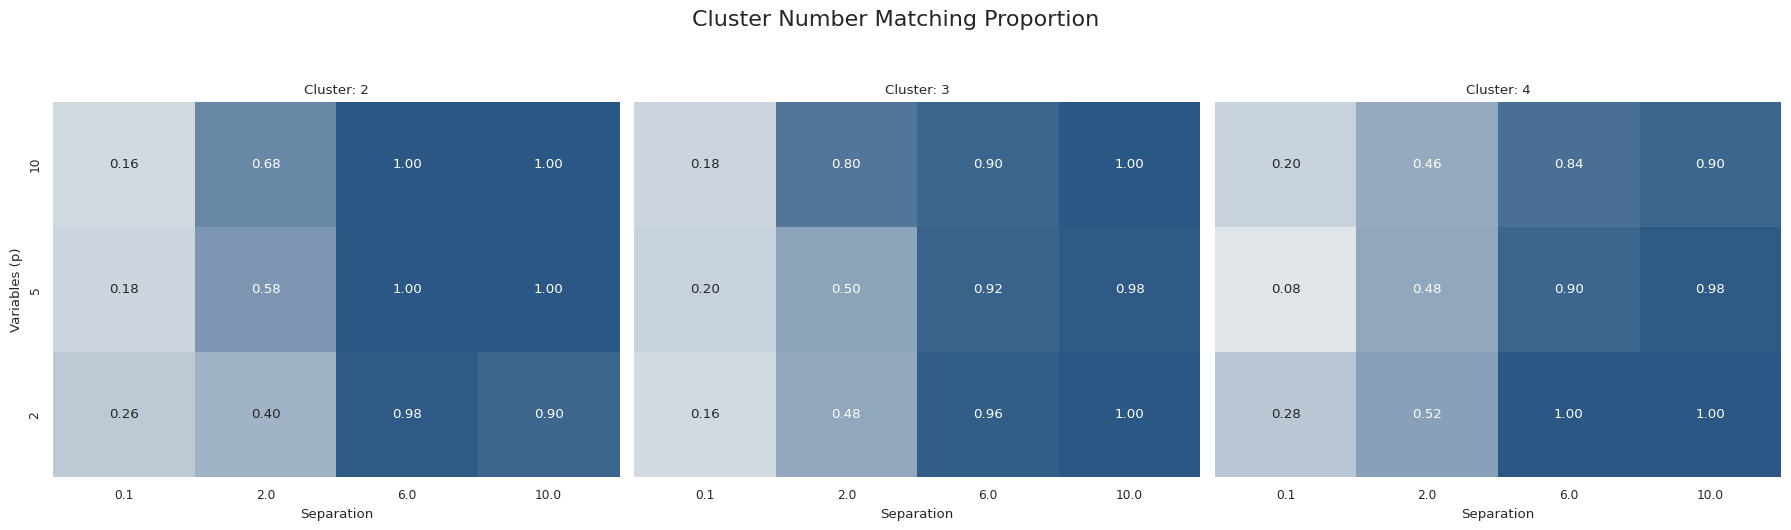

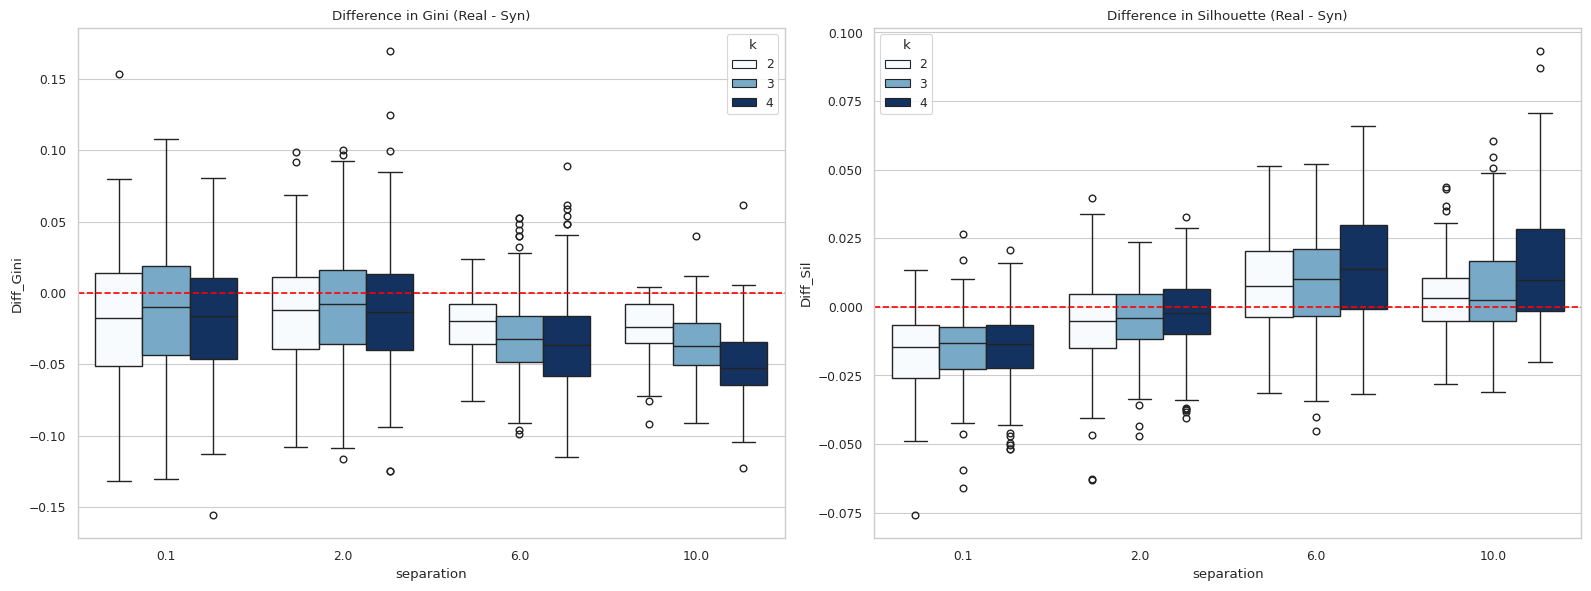


✅ Analysis Complete.


In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import itertools
from joblib import Parallel, delayed
from tqdm import tqdm
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import cdist
from scipy.optimize import linear_sum_assignment

# Set plot style
sns.set_theme(style="whitegrid", context="paper")

# ==========================================
# 1. METRIC FUNCTIONS
# ==========================================
def gini_coefficient(x):
    """Calculates Gini coefficient of array x."""
    x = np.array(x, dtype=np.float64)
    if np.amin(x) < 0: x -= np.amin(x)
    x += 0.0000001
    x = np.sort(x)
    n = x.shape[0]
    index = np.arange(1, n + 1)
    return ((np.sum((2 * index - n - 1) * x)) / (n * np.sum(x)))

def get_optimal_k(data, max_k=10, random_state=123):
    """Finds optimal k for K-Means using Silhouette Score."""
    best_score = -1
    best_k = 2
    best_model = None
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(data)
    
    # If data is too small, default to k=2
    if len(data) < max_k:
        return 2, KMeans(n_clusters=2, random_state=random_state).fit(data_scaled), data_scaled

    for k in range(2, max_k + 1):
        km = KMeans(n_clusters=k, n_init=10, random_state=random_state)
        labels = km.fit_predict(data_scaled)
        
        # Silhouette requires at least 2 clusters to be calculated
        if len(np.unique(labels)) < 2: continue
            
        score = silhouette_score(data_scaled, labels)
        if score > best_score:
            best_score = score
            best_k = k
            best_model = km
    return best_k, best_model, data_scaled

def match_clusters(real_model, syn_model):
    """Aligns synthetic clusters to real clusters using Hungarian Algo."""
    real_centers = real_model.cluster_centers_
    syn_centers = syn_model.cluster_centers_
    dists = cdist(real_centers, syn_centers, metric='euclidean')
    real_indices, syn_indices = linear_sum_assignment(dists)
    mapping = {syn_idx: real_idx for real_idx, syn_idx in zip(real_indices, syn_indices)}
    return mapping

# ==========================================
# 2. PROCESSING WORKER
# ==========================================
def process_simulation_file(params, data_dir="../simulation_data"):
    # Unpack parameters
    N, p, k, sep, seed = params['N'], params['p'], params['k'], params['sep'], params['seed']
    rho = 0.0
    
    # Match R's sprintf() formatting
    sep_str = f"{sep:g}" 
    rho_str = f"{rho:g}"
    
    # Construct filename
    file_base = f"sim_N{N}_p{p}_k{k}_sep{sep_str}_rho{rho_str}_seed{seed}"
    real_path = os.path.join(data_dir, f"{file_base}_real.csv")
    syn_path = os.path.join(data_dir, f"{file_base}_syn.csv")
    
    if not os.path.exists(real_path):
        return None

    try:
        # Load Data
        real_df = pd.read_csv(real_path)
        syn_df = pd.read_csv(syn_path)
        
        X_real = real_df.drop(columns=['group'], errors='ignore')
        X_syn = syn_df.drop(columns=['group'], errors='ignore')
        
        # --- 1. Real Data Clustering ---
        # Find optimal k for Real Data
        real_k_found, real_model, real_scaled = get_optimal_k(X_real, max_k=10, random_state=seed)
        
        # --- 2. Synthetic Data "Blind" Clustering (For Success Metric) ---
        # Find optimal k for Synthetic Data independently
        syn_k_found, _, _ = get_optimal_k(X_syn, max_k=10, random_state=seed)
        
        # CORRECTED SUCCESS METRIC: Does Syn structure match Real structure?
        # (Replicates R logic: real.k == synt.k)
        success = 1 if real_k_found == syn_k_found else 0
        
        # --- 3. Synthetic Data "Forced" Clustering (For Gini/Sil Diff Metrics) ---
        # To calculate metrics like Gini difference fairly, we must align clusters.
        # We force the synthetic data to be clustered using the SAME k found in Real data.
        scaler = StandardScaler()
        syn_scaled = scaler.fit_transform(X_syn)
        
        # Force k to match real_k_found for metric comparison
        syn_model_forced = KMeans(n_clusters=real_k_found, n_init=10, random_state=seed)
        syn_labels_raw = syn_model_forced.fit_predict(syn_scaled)
        
        # Match Labels (Hungarian Algorithm)
        mapping = match_clusters(real_model, syn_model_forced)
        syn_labels_mapped = np.array([mapping[label] for label in syn_labels_raw])
        
        # --- 4. Calculate Metrics ---
        # Real Metrics
        real_labels = real_model.labels_
        real_counts = np.bincount(real_labels)
        real_gini = gini_coefficient(real_counts)
        real_sil = silhouette_score(real_scaled, real_labels)
        
        # Syn Metrics (using the forced model)
        syn_counts = np.bincount(syn_labels_mapped)
        syn_gini = gini_coefficient(syn_counts)
        syn_sil = silhouette_score(syn_scaled, syn_labels_mapped)
        
        return {
            "N": N, "p": p, "k": k, "separation": sep,
            "seed": seed,
            "success": success,     # Corrected metric
            "k_real": real_k_found, # Track found k
            "k_syn": syn_k_found,   # Track found syn k
            "Diff_Gini": real_gini - syn_gini,
            "Diff_Sil": real_sil - syn_sil
        }
    except Exception as e:
        return {"error": str(e), **params}

# ==========================================
# 3. MAIN EXECUTION
# ==========================================
if __name__ == "__main__":
    # Define Grid (Must match your R script)
    N_list = [250]
    p_list = [2, 5, 10]
    k_list = [2, 3, 4]
    sep_list = [0.1, 2, 6, 10]
    n_simulations = 1000 

    # Create Job List
    keys = ['N', 'p', 'k', 'sep']
    combinations = itertools.product(N_list, p_list, k_list, sep_list)
    param_grid = []

    for values in combinations:
        base_params = dict(zip(keys, values))
        # R uses 1-based indexing for seeds in the loop
        for i in range(1, n_simulations + 1): 
            params = base_params.copy()
            params['seed'] = i
            param_grid.append(params)

    print(f"🚀 Processing {len(param_grid)} datasets from 'simulation_data/'...")

    # Run Parallel
    results_list = Parallel(n_jobs=-1)(
        delayed(process_simulation_file)(params) for params in tqdm(param_grid)
    )

    # Filter empty results (failed files)
    results_list = [r for r in results_list if r is not None]
    df_results = pd.DataFrame(results_list)
    
    print(f"✅ Successfully processed {len(df_results)} datasets")

    # ==========================================
    # 4. PLOTTING
    # ==========================================
    if not df_results.empty:
        # A. Heatmap
        df_summary = df_results.groupby(['k', 'p', 'separation'])['success'].mean().reset_index()
        k_values = sorted(df_summary['k'].unique())
        
        fig, axes = plt.subplots(1, len(k_values), figsize=(18, 5), sharey=True)
        # Handle single subplot case if only one k is tested
        if len(k_values) == 1: axes = [axes]
            
        cmap = sns.light_palette("#2A5783", as_cmap=True)

        for i, k_val in enumerate(k_values):
            data_k = df_summary[df_summary['k'] == k_val]
            heatmap_data = data_k.pivot(index="p", columns="separation", values="success")
            heatmap_data = heatmap_data.sort_index(ascending=False) 
            
            sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap=cmap, vmin=0, vmax=1, ax=axes[i], cbar=False)
            axes[i].set_title(f"Cluster: {k_val}")
            axes[i].set_xlabel("Separation")
            if i == 0: axes[i].set_ylabel("Variables (p)")
            else: axes[i].set_ylabel("")

        plt.suptitle("Cluster Number Matching Proportion", y=1.05, fontsize=16)
        plt.tight_layout()
        plt.show()
        
        # B. Boxplots
        fig, axes = plt.subplots(1, 2, figsize=(16, 6))
        sns.boxplot(data=df_results, x="separation", y="Diff_Gini", hue="k", palette="Blues", ax=axes[0])
        axes[0].set_title("Difference in Gini (Real - Syn)")
        axes[0].axhline(0, color='red', linestyle='--')

        sns.boxplot(data=df_results, x="separation", y="Diff_Sil", hue="k", palette="Blues", ax=axes[1])
        axes[1].set_title("Difference in Silhouette (Real - Syn)")
        axes[1].axhline(0, color='red', linestyle='--')
        plt.tight_layout()
        plt.show()
        
        print("\n✅ Analysis Complete.")
    else:
        print("❌ No data found. Please ensure the R script has run and 'simulation_data/' is populated.")